In [1]:
import numpy as np
import math
import itertools
import random
import time

import matplotlib
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid

import torch

import models as MetaSRGAN
from QuickImageDatasets import ImageDataset

from plotAllLosses import plotLosses, checkBound, avg_loss

In [2]:
def seperateImgs(metaData):
    if len(metaData.shape) == 4:
        return metaData[:,0:3]
    elif len(metaData.shape) == 3:
        return metaData[0:3]
    else:
        print("Cannot seperate images from a tensor with shape of " + str(metaData.shape))
def seperateMetas(metaData):
    if len(metaData.shape) == 4:
        return metaData[:,3:8]
    elif len(metaData.shape) == 3:
        return metaData[3:8]
    else:
        print("Cannot seperate metas from a tensor with shape of " + str(metaData.shape))

In [3]:
def generatorPath(epoch):
    return saved_model_path + model_name + ("_generator_%d.pth" % epoch)
def discriminatorPath(epoch):
    return saved_model_path + model_name + ("_discriminator_%d.pth" % epoch)
def baseGeneratorPath(epoch):
    return saved_model_path + srgan_name + ("_generator_%d.pth" % epoch)
def autoencoderPath(epoch):
    return saved_model_path + encoder_name + ("_%d.pth" % epoch)

In [4]:
def save_sample(imgs, epoch):
    batch_size = 8 if imgs[0].shape[0] > 8 else imgs[0].shape[0]
    grid_imgs = []
    for img_seq in imgs:
        grid_imgs.append(make_grid(img_seq[0:batch_size], nrow=1, normalize=False))
    imgs_all = torch.cat(grid_imgs, dim=-1)
    save_image(imgs_all, sample_path + model_name + ("_%d.png" % epoch))

In [5]:
cuda = torch.cuda.is_available()

hr_shape = (256,256)
dataset_root = "X:/Datasets/"
trainset_name = "SuperRes3_train"
testset_name = "SuperRes3_test"
batch_size = 16
starting_epoch = 0
epochs = 200

saved_model_path = "../SavedModels/"
model_name       = "QuickGAN_2_4"
encoder_name     = "DNO_Autoencoder"
encoder_epoch    = 50
srgan_name       = "SRGAN_Full_1_0"
srgan_epoch      = 325

sample_path = "../Samples/"

In [6]:
generator         = MetaSRGAN.GeneratorResNet()
baseGenerator     = MetaSRGAN.GeneratorSlowNet()
discriminator     = MetaSRGAN.Discriminator(input_shape=(3, *hr_shape))
feature_extractor = MetaSRGAN.FeatureExtractor()
encoder           = MetaSRGAN.MetaAutoencoderTail()

X:\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
X:\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
if starting_epoch > 0:
    generator.load_state_dict(torch.load(generatorPath(starting_epoch)))
    discriminator.load_state_dict(torch.load(discriminatorPath(starting_epoch)))
encoder.load_state_dict(torch.load(autoencoderPath(encoder_epoch)))
encoder.eval()
baseGenerator.load_state_dict(torch.load(slowGeneratorPath(srgan_epoch)))
baseGenerator.eval()
feature_extractor.eval()

FeatureExtractor(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3

In [8]:
#Loss functions
criterion_GAN = torch.nn.MSELoss()
criterion_content = torch.nn.L1Loss()

In [9]:
if cuda:
    print("Training on GPU")
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    baseGenerator = baseGenerator.cuda()
    encoder = encoder.cuda()
    feature_extractor = feature_extractor.cuda()
    criterion_GAN = criterion_GAN.cuda()
    criterion_content = criterion_content.cuda()
    
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

Training on GPU


In [10]:
#optimizers
learning_rate = 0.0002
optimizer_G  = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D  = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

In [11]:
train_loader = torch.utils.data.DataLoader(
    dataset=ImageDataset(dataset_root + trainset_name, hr_shape), 
    batch_size=batch_size, 
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=ImageDataset(dataset_root + testset_name, hr_shape), 
    batch_size=batch_size, 
    shuffle=True
)

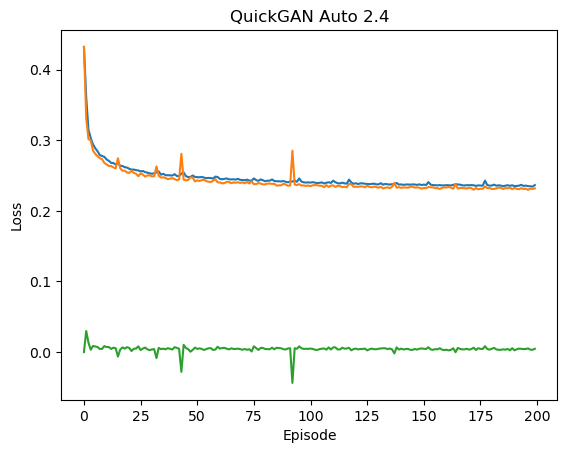

[Epoch 200/200] 
[Generator Train: 0.236506] 
[Generator Test: 0.231848] [Generator Delta: 0.004658] 
Elapsed Time 46:19:9


In [12]:
generatorTrainLosses = []
generatorTestLosses  = []
discriminatorTrainLosses = []
discriminatorTestLosses  = []
generatorDeltas = []
discriminatorDeltas = []

lossLabels = ["Generator Train", "Generator Test", "Generator Delta"]

start_time = time.time()

depth, hr_depth, normal, hr_normal, obj, hr_obj, hr_imgs, hr_inf = None, None, None, None, None, None, None, None

for epoch in range(starting_epoch, epochs):
    torch.set_grad_enabled(True)
    holdGenLosses     = []
    holdDisLosses     = []
    for i, imgs in enumerate(train_loader):
        lr_imgs = Variable(seperateImgs(imgs["lr"]).type(Tensor))
        hr_imgs = Variable(seperateImgs(imgs["hr"]).type(Tensor))
        lr_metas = Variable(seperateMetas(imgs["lr"]).type(Tensor))
        hr_metas = Variable(seperateMetas(imgs["hr"]).type(Tensor))
        
        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((lr_imgs.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((lr_imgs.size(0), *discriminator.output_shape))), requires_grad=False)
        
        depth  = lr_metas[:, 0:1]
        normal = lr_metas[:, 1:4]
        obj    = lr_metas[:, 4:5]
        b, c, h, w = lr_metas.shape
        
        depth  = torch.cat((depth, depth, depth), 1)
        obj    = torch.cat((obj, obj, obj), 1)
        
        depth  = baseGenerator(depth)
        normal = baseGenerator(normal)
        obj    = baseGenerator(obj)
        
        hr_depth  = hr_metas[:, 0:1]
        hr_normal = hr_metas[:, 1:4]
        hr_obj    = hr_metas[:, 4:5]
        
        hr_depth  = torch.cat((hr_depth, hr_depth, hr_depth), 1)
        hr_obj    = torch.cat((hr_obj, hr_obj, hr_obj), 1)
        
        # =============== construct metas =======================
        depth = depth[:, 0:1]
        obj   = obj[:, 0:1]
        hr_metas = torch.cat((depth, normal, obj), 1)
        
        meta_vec = encoder(hr_metas)
        
        #========== Train Generator =====================
        optimizer_G.zero_grad()
        #Inference
        hr_inf = generator(lr_imgs, meta_vec)
        #Adversarial loss
        loss_GAN = criterion_GAN(discriminator(hr_inf), valid)
        #Content loss
        inf_features  = feature_extractor(hr_inf)
        real_features = feature_extractor(hr_imgs)
        loss_content  = criterion_content(inf_features, real_features.detach())
        #total loss
        loss_G = loss_content + 1e-3 * loss_GAN
        loss_G.backward()
        optimizer_G.step()
        
        #========= Train Discriminator ==================
        optimizer_D.zero_grad()
        #loss of real and fake images
        loss_real = criterion_GAN(discriminator(hr_imgs), valid)
        loss_fake = criterion_GAN(discriminator(hr_inf.detach()), fake)
        #total loss
        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        optimizer_D.step()
        
        holdGenLosses.append(loss_G.item())
        holdDisLosses.append(loss_D.item())
    
    if epoch > 0:
        generatorTrainLosses.append(avg_loss(holdGenLosses))
        discriminatorTrainLosses.append(avg_loss(holdDisLosses))
    
    torch.save(generator.state_dict(), generatorPath(epoch+1))
    torch.save(discriminator.state_dict(), discriminatorPath(epoch+1))
    
    save_sample([depth, hr_depth, normal, hr_normal, obj, hr_obj, hr_inf, hr_imgs], epoch + 1)
    
    torch.set_grad_enabled(False)
    holdGenLosses     = []
    holdSlowGenLosses = []
    for i, imgs in enumerate(test_loader):
        lr_imgs = Variable(seperateImgs(imgs["lr"]).type(Tensor))
        hr_imgs = Variable(seperateImgs(imgs["hr"]).type(Tensor))
        lr_metas = Variable(seperateMetas(imgs["lr"]).type(Tensor))
        hr_metas = Variable(seperateMetas(imgs["hr"]).type(Tensor))
        
        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((lr_imgs.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((lr_imgs.size(0), *discriminator.output_shape))), requires_grad=False)
        
        depth  = lr_metas[:, 0:1]
        normal = lr_metas[:, 1:4]
        obj    = lr_metas[:, 4:5]
        b, c, h, w = lr_metas.shape
        
        depth  = torch.cat((depth, depth, depth), 1)
        obj    = torch.cat((obj, obj, obj), 1)
        
        depth  = baseGenerator(depth)
        normal = baseGenerator(normal)
        obj    = baseGenerator(obj)
        
        #============= Construct Metas =======================
        depth = depth[:, 0:1]
        obj   = obj[:, 0:1]
        hr_metas = torch.cat((depth, normal, obj), 1)
        
        meta_vec = encoder(hr_metas)
        
        #========== Train Generator =====================
        optimizer_G.zero_grad()
        #Inference
        hr_inf = generator(lr_imgs, meta_vec)
        #Adversarial loss
        loss_GAN = criterion_GAN(discriminator(hr_inf), valid)
        #Content loss
        inf_features  = feature_extractor(hr_inf)
        real_features = feature_extractor(hr_imgs)
        loss_content  = criterion_content(inf_features, real_features.detach())
        #total loss
        loss_G = loss_content + 1e-3 * loss_GAN
        
        #========= Train Discriminator ==================
        #loss of real and fake images
        loss_real = criterion_GAN(discriminator(hr_imgs), valid)
        loss_fake = criterion_GAN(discriminator(hr_inf.detach()), fake)
        #total loss
        loss_D = (loss_real + loss_fake) / 2
        
        holdGenLosses.append(loss_G.item())
        holdDisLosses.append(loss_D.item())
    
    generatorTestLosses.append(avg_loss(holdGenLosses))
    discriminatorTestLosses.append(avg_loss(holdDisLosses))
    if epoch == 0:
        generatorTrainLosses.append(generatorTestLosses[-1])
        discriminatorTrainLosses.append(discriminatorTestLosses[-1])
    generatorDeltas.append(generatorTrainLosses[-1] - generatorTestLosses[-1])
    discriminatorDeltas.append(discriminatorTrainLosses[-1] - discriminatorTestLosses[-1])
    plotLosses(
        "MetaSRGAN",
        epoch+1,
        epochs,
        [generatorTrainLosses, generatorTestLosses, generatorDeltas],
        lossLabels,
        start_time
    )